# Logistic Regression, Prediction and ROC


Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

# Table of Contents
1. [Credit Card Default Data](#1-credit-card-default-data)  
2. [Logistic Regression](#2-logistic-regression)  
   2.1 [Train a logistic regression model with all variables](#21-train-a-logistic-regression-model-with-all-variables)  
   2.2 [Prediction](#22-prediction)  
   2.2.1 [In-sample prediction (less important)](#221-in-sample-prediction-less-important)  
   2.2.2 [Out-of-sample prediction (more important)](#222-out-of-sample-prediction-more-important)  
   2.2.3 [(Optional) Precision-Recall Curve](#223-optional-precision-recall-curve)  
3. [Summary](#3-summary)  
   3.1 [Things to remember](#31-things-to-remember)  
   3.2 [Guide for Assignment](#32-guide-for-assignment)  


#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1BUuyyGQuoP3mrYmHZDMzxqwKM7yx5hus?usp=sharing)*
#### *Useful information about [Logistic Regression, Prediction and ROC](https://yanyudm.github.io/Data-Mining-R/lecture/4.D_LogisticReg_ROC.html)*





# 1 Credit Card Default Data

We will use a subset of the Credit Card Default Data (sample size $n = 12{,}000$) for this lab and illustration. Details of the full dataset ($n = 30{,}000$) can be found at: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Think about what kinds of factors could cause people to fail to pay their credit card balance.

We first load the credit scoring data. It is easy to load comma-separated values (CSV).


In [1]:
# Google Colab Python equivalent of the provided R code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
# Load data
url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(url)




Look at what information do we have.



In [2]:
# colnames(credit_data)
# Two column names per line
cols = list(credit_data.columns)
for i in range(0, len(cols), 2):
    if i + 1 < len(cols):
        print(f"{cols[i]}\t{cols[i+1]}")
    else:
        print(cols[i])

LIMIT_BAL	SEX
EDUCATION	MARRIAGE
AGE	PAY_0
PAY_2	PAY_3
PAY_4	PAY_5
PAY_6	BILL_AMT1
BILL_AMT2	BILL_AMT3
BILL_AMT4	BILL_AMT5
BILL_AMT6	PAY_AMT1
PAY_AMT2	PAY_AMT3
PAY_AMT4	PAY_AMT5
PAY_AMT6	default.payment.next.month


Let’s look at how many people were actually default in this sample.



In [3]:

# mean(credit_data$default.payment.next.month)
mean_default = credit_data["default.payment.next.month"].mean()
print(f"Mean default.payment.next.month: {mean_default:.4f}")



Mean default.payment.next.month: 0.2193


The name of response variable is too long! I want to make it shorter by renaming. Recall the rename() function.



In [4]:
#  rename default.payment.next.month -> default
credit_data = credit_data.rename(columns={"default.payment.next.month": "default"})

How about the variable type and summary statistics?



In [5]:
#  str(credit_data) and summary(credit_data)
print("\n--- credit_data.info() ---")
credit_data.info()

print("\n--- credit_data.describe(include='all') ---")

# Make numeric summaries show 2 decimal places
desc = credit_data.describe(include="all").T
num_cols = desc.select_dtypes(include=["number"]).columns
desc[num_cols] = desc[num_cols].round(2)

display(desc)




--- credit_data.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  12000 non-null  int64
 1   SEX        12000 non-null  int64
 2   EDUCATION  12000 non-null  int64
 3   MARRIAGE   12000 non-null  int64
 4   AGE        12000 non-null  int64
 5   PAY_0      12000 non-null  int64
 6   PAY_2      12000 non-null  int64
 7   PAY_3      12000 non-null  int64
 8   PAY_4      12000 non-null  int64
 9   PAY_5      12000 non-null  int64
 10  PAY_6      12000 non-null  int64
 11  BILL_AMT1  12000 non-null  int64
 12  BILL_AMT2  12000 non-null  int64
 13  BILL_AMT3  12000 non-null  int64
 14  BILL_AMT4  12000 non-null  int64
 15  BILL_AMT5  12000 non-null  int64
 16  BILL_AMT6  12000 non-null  int64
 17  PAY_AMT1   12000 non-null  int64
 18  PAY_AMT2   12000 non-null  int64
 19  PAY_AMT3   12000 non-null  int64
 20  PAY_AMT4   12000 non-n

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,12000.0,167501.33,130334.21,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,12000.0,1.60,0.49,1.0,1.00,2.0,2.00,2.0
EDUCATION,12000.0,1.84,0.75,1.0,1.00,2.0,2.00,4.0
MARRIAGE,12000.0,1.55,0.52,1.0,1.00,2.0,2.00,3.0
AGE,12000.0,35.50,9.23,21.0,28.00,34.0,41.00,79.0
PAY_0,12000.0,-0.02,1.13,-2.0,-1.00,0.0,0.00,8.0
PAY_2,12000.0,-0.13,1.19,-2.0,-1.00,0.0,0.00,7.0
PAY_3,12000.0,-0.17,1.19,-2.0,-1.00,0.0,0.00,7.0
PAY_4,12000.0,-0.23,1.15,-2.0,-1.00,0.0,0.00,7.0
PAY_5,12000.0,-0.27,1.12,-2.0,-1.00,0.0,0.00,7.0


We see all variables are int, but we know that SEX, EDUCATION, MARRIAGE are categorical, we convert them to factor.



In [6]:
# Convert to factors (categorical)
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")



We omit other EDA, but you shouldn’t whenever you are doing data analysis.



# 2 Logistic Regression
Randomly split the data to training (80%) and testing (20%) datasets:

In [7]:
#  Train/test split (80/20) similar to R's sample()
np.random.seed(123)  # for reproducibility
n = len(credit_data)
train_idx = np.random.choice(credit_data.index, size=int(0.80 * n), replace=False)

credit_train = credit_data.loc[train_idx].copy()
credit_test  = credit_data.drop(train_idx).copy()

## 2.1 Train a logistic regression model with all variables


In [8]:
# Fit logistic regression: glm(default ~ ., family=binomial, data=credit_train)
# Build a formula that treats selected columns as categorical (like factors in R)
y_col = "default"
x_cols = [c for c in credit_train.columns if c != y_col]
cat_cols = {"SEX", "EDUCATION", "MARRIAGE"}

rhs_terms = [f"C({c})" if c in cat_cols else c for c in x_cols]
formula = f"{y_col} ~ " + " + ".join(rhs_terms)

credit_glm0 = smf.glm(formula=formula, data=credit_train, family=sm.families.Binomial()).fit()
print(credit_glm0.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 9600
Model:                            GLM   Df Residuals:                     9573
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4444.0
Date:                Sun, 04 Jan 2026   Deviance:                       8888.0
Time:                        06:08:31   Pearson chi2:                 1.12e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1204
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0468      0.15

## 2.2 Prediction

To obtain predictions from a logistic regression model, there are several steps you should understand.  
(Refer to the textbook/slides for the detailed mathematics.)

1. **The fitted model**  
   $$\hat{\eta} = b_0 + b_1 x_1 + b_2 x_2 + \cdots$$  
   gives the estimated linear predictor (i.e., before applying the inverse link).  
   In logistic regression, $\hat{\eta}$ is the estimated **log-odds**:  
   $$\hat{\eta} = \log\left(\frac{P(y=1)}{1-P(y=1)}\right).$$

2. **Convert log-odds to probability**  
   To obtain the predicted probability $P(y=1)$, apply the inverse logit (sigmoid) function:  
   $$\hat{p} = \frac{1}{1 + e^{-\hat{\eta}}}.$$

3. **Getting predictions in Python (scikit-learn)**  

When you fit a logistic regression model in Python using `sklearn`, the trained model provides:

- `model.predict_proba(X)` for predicted probabilities  
- `model.decision_function(X)` for the linear predictor (log-odds)

```python
# Assume X_train, y_train are your data and model is already fitted.

# Linear predictor (log-odds)
eta = model.decision_function(X_train)

# Predicted probabilities for class 1
p = model.predict_proba(X_train)[:, 1]


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


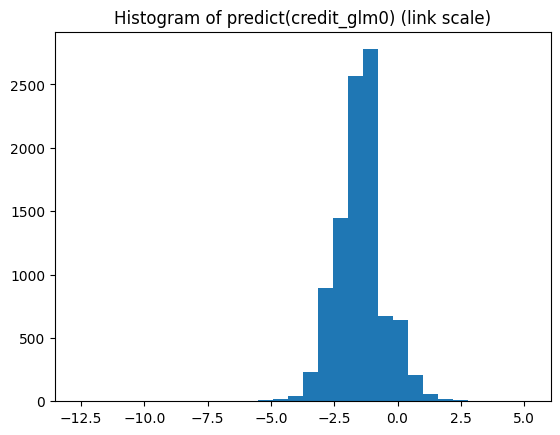

In [9]:
lin_pred_train = credit_glm0.predict(credit_train, linear=True)   # link scale (log-odds)
plt.figure()
plt.hist(lin_pred_train, bins=30)
plt.title("Histogram of predict(credit_glm0) (link scale)")
plt.show()



4. Converting log-odds $(\hat{\eta})$ to the predicted probability $P(y=1)$

For each estimated log-odds $\hat{\eta}$ (the linear predictor), we obtain the predicted probability by applying the **inverse logit** (sigmoid) function:

$$
\hat{P}(y=1) = \frac{1}{1 + \exp(-\hat{\eta})}.
$$

In **Python with `statsmodels`**, you can obtain predicted probabilities on the training data (in-sample) in several equivalent ways:

```python
model.predict(X)


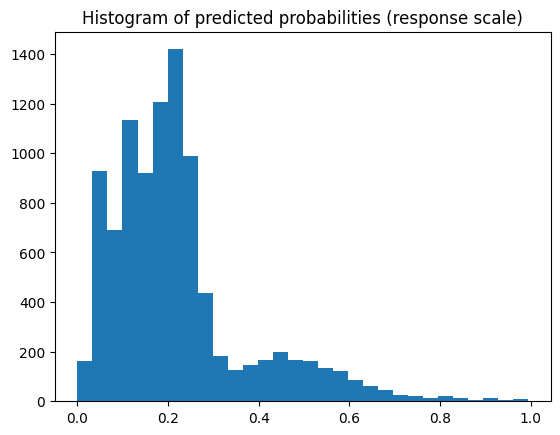

In [10]:
pred_resp = credit_glm0.predict(credit_train)                     # response scale (prob)
plt.figure()
plt.hist(pred_resp, bins=30)
plt.title("Histogram of predicted probabilities (response scale)")
plt.show()

5. Turning Predicted Probabilities into Binary Decisions

Finally, we need a **classification rule** to convert the predicted probability $\hat{P}(y=1)$ into a final 0/1 prediction.

- The **default threshold (cutoff)** is **0.5**:  
  → If $\hat{P}(y=1) > 0.5$, predict **default = 1**  
  → Otherwise, predict **default = 0**

- You can (and often should) adjust this threshold depending on the business objective.

#### Why the threshold matters: cost asymmetry in credit scoring

| True \\ Predicted | Predict 0 (no default) | Predict 1 (default) |
|---|---|---|
| **Actual 0 (repays)** | Correct decision | **Rejected good customer** (opportunity cost) |
| **Actual 1 (defaults)** | **Approved loan → loss** | Correct decision |

- **False Negative** (predict 0, actual 1): approved a loan to someone who defaults → typically very costly  
- **False Positive** (predict 1, actual 0): rejected a customer who would repay → typically less costly  

In many credit-scoring applications, we therefore prefer a **lower threshold** (e.g., 0.2–0.3) to flag more potential defaulters.


In [11]:
# Confusion tables at multiple cutoffs (train)
# -----------------------------
def confusion_table(y_true, prob, threshold):
    y_true = np.asarray(y_true).astype(int)
    prob = np.asarray(prob, dtype=float)
    y_pred = (prob > threshold).astype(int)
    return pd.crosstab(
        pd.Series(y_true, name="Truth"),
        pd.Series(y_pred, name="Predicted"),
        dropna=False
    )

for thr in [0.5, 0.2, 0.0001]:
    print(f"\n--- Train confusion table (cutoff={thr}) ---")
    display(confusion_table(credit_train["default"], pred_resp, thr))

# Keep a named variable like the R code
pred_glm0_train = pred_resp


--- Train confusion table (cutoff=0.5) ---


Predicted,0,1
Truth,,
0,7293,194
1,1591,522



--- Train confusion table (cutoff=0.2) ---


Predicted,0,1
Truth,,
0,4462,3025
1,625,1488



--- Train confusion table (cutoff=0.0001) ---


Predicted,0,1
Truth,,
0,2,7485
1,0,2113


### IMPORTANT!!! Understanding `predict()` in Python (`statsmodels`)

**Unlike R, the default behavior in `statsmodels` is to return predicted probabilities.**

| What you want | Code in Python (`statsmodels`) | What you get |
|---|---|---|
| **Predicted probability** $\hat{P}(y=1)$ (this is what we most often want) | `credit_glm0.predict(X)` | **Default behavior** → probabilities (0 to 1) |
| Predicted log-odds (linear predictor) $\hat{\eta} = \beta_0 + \beta_1 X_1 + \cdots$ | `credit_glm0.predict(X, linear=True)` | You must explicitly request it |

**So in Python (`statsmodels`):**

- You **do not** need any extra option to get probabilities—`predict(X)` already returns $\hat{P}(y=1)$.  
- You **must** add `linear=True` if you want the linear predictor (log-odds).

**Recall from the lecture:**

The linear predictor $\hat{\eta}$ is related to probability via the **logistic (sigmoid) function**:

$$
\hat{P}(y=1) = \frac{1}{1 + e^{-\hat{\eta}}}
\quad \text{where} \quad
\hat{\eta} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots
$$

**Rule of thumb (write this in your notes):**

```python
credit_glm0.predict(X)               # → P(default = 1)       (use most of the time)
credit_glm0.predict(X, linear=True)  # → log-odds (η-hat)     (only when specifically needed)


To provide an overall measure of classification performance, one common approach is the **Receiver Operating Characteristic (ROC) curve**. Rather than relying on a single misclassification rate, the ROC curve summarizes performance across all possible thresholds using two quantities: the **true positive fraction (TPF)** and the **false positive fraction (FPF)**.

- **True positive fraction (TPF)**:  
  $$\text{TPF} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$  
  This is the proportion of actual positives that are correctly predicted as positive.

- **False positive fraction (FPF)**:  
  $$\text{FPF} = \frac{\text{FP}}{\text{FP} + \text{TN}} = 1 - \frac{\text{TN}}{\text{FP} + \text{TN}}$$  
  This is the proportion of actual negatives that are incorrectly predicted as positive.


### 2.2.1 In-sample prediction (less important)


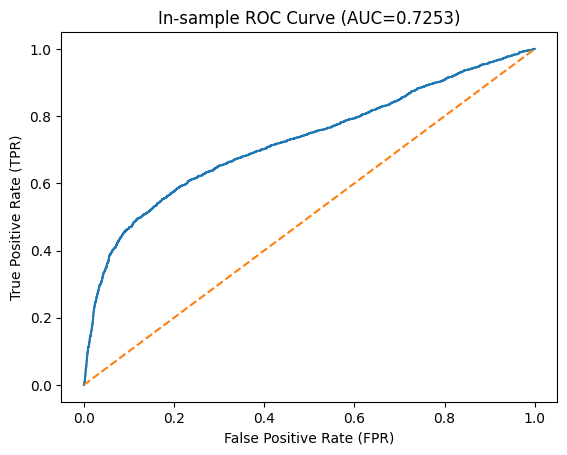

In-sample AUC: 0.725262


In [12]:

y_train = credit_train["default"].astype(int).values
fpr_tr, tpr_tr, thr_tr = roc_curve(y_train, pred_glm0_train)
auc_tr = roc_auc_score(y_train, pred_glm0_train)

plt.figure()
plt.plot(fpr_tr, tpr_tr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"In-sample ROC Curve (AUC={auc_tr:.4f})")
plt.show()

print(f"In-sample AUC: {auc_tr:.6f}")

### 2.2.2 Out-of-sample prediction (more important)
#### 2.2.2.1 ROC Curve



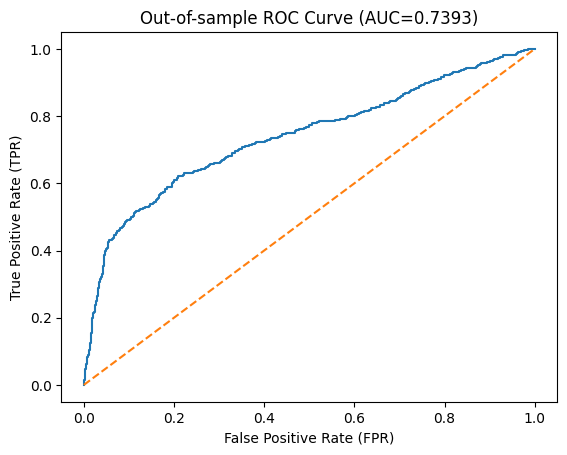

Out-of-sample AUC: 0.739347


In [13]:
# Out-of-sample prediction (test) + ROC/AUC
#    R: pred_glm0_test <- predict(credit_glm0, newdata=credit_test, type="response")
# -----------------------------
pred_glm0_test = credit_glm0.predict(credit_test)
y_test = credit_test["default"].astype(int).values

fpr_te, tpr_te, thr_te = roc_curve(y_test, pred_glm0_test)
auc_te = roc_auc_score(y_test, pred_glm0_test)

plt.figure()
plt.plot(fpr_te, tpr_te)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"Out-of-sample ROC Curve (AUC={auc_te:.4f})")
plt.show()

print(f"Out-of-sample AUC: {auc_te:.6f}")

### 2.2.3 (Optional) Precision–Recall Curve

**The Precision–Recall (PR) curve and its AUC are often more appropriate when the data are imbalanced.**

In highly imbalanced datasets (e.g., only 5–20% defaults), the **ROC curve can appear overly optimistic**.  
A useful alternative is the **Precision–Recall (PR) curve**, which emphasizes performance on the positive (minority) class.

In Python, we can use **scikit-learn** and **matplotlib** to plot the PR curve and compute its AUC (Average Precision) — no additional packages are needed.


AP in the in-sample Precision–Recall (PR) curve output is **Average Precision**.

In **scikit-learn**, `average_precision_score(y_true, y_score)` returns **AP**, which is a single-number summary of the PR curve.

Conceptually, AP is the **area under the Precision–Recall curve**, computed as a weighted average of precision values, where the weights are the increases in recall:

$$
\mathrm{AP} = \sum_{k} (R_k - R_{k-1}) \, P_k
$$

where $P_k$ and $R_k$ are the precision and recall values at successive thresholds.

**Interpretation:**

- Higher AP is better.
- The baseline AP is approximately the **prevalence of the positive class** (e.g., if 22% of customers default, a random ranking has $\mathrm{AP} \approx 0.22$).
- “In-sample AP” means you computed this on the training set, so it can be **optimistically biased** compared with out-of-sample AP on the test set.


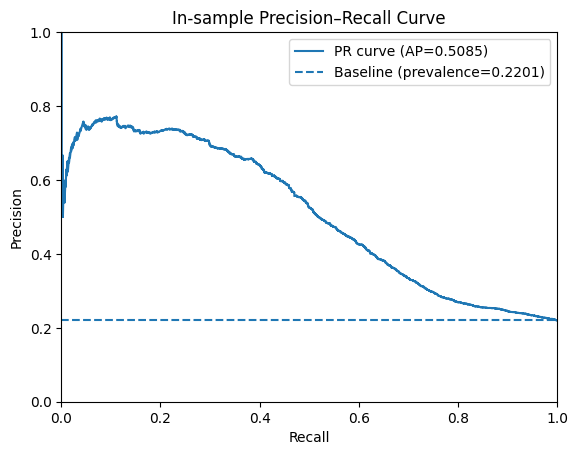

In-sample AP (PR AUC): 0.5085
Baseline AP (train prevalence): 0.2201


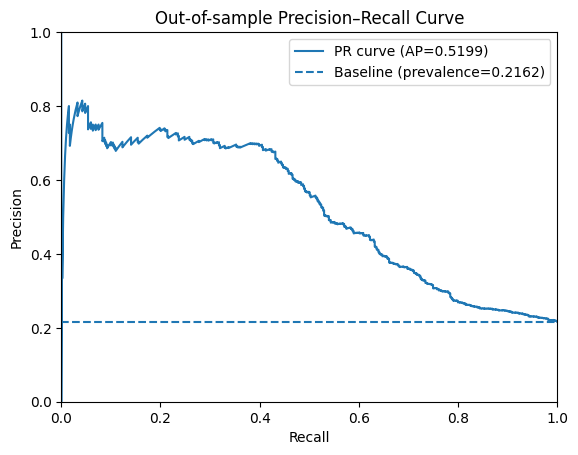

Out-of-sample AP (PR AUC): 0.5199
Baseline AP (test prevalence):  0.2162


In [14]:
# ------------------------------------------------------------
# (Optional) Precision–Recall (PR) Curve + AUC (Average Precision)
# Appropriate for imbalanced data (e.g., low default rate)
# ------------------------------------------------------------
# Precision–Recall (PR) Curves with AP + Baseline (prevalence) shown on the plots
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

y_train = credit_train["default"].astype(int).values
y_test  = credit_test["default"].astype(int).values

# Predicted probabilities (assumes these already exist; uncomment if needed)
# pred_glm0_train = credit_glm0.predict(credit_train)
# pred_glm0_test  = credit_glm0.predict(credit_test)

# Baseline APs (prevalence)
baseline_train = y_train.mean()
baseline_test = y_test.mean()

# -------- In-sample PR curve --------
precision_tr, recall_tr, _ = precision_recall_curve(y_train, pred_glm0_train)
ap_tr = average_precision_score(y_train, pred_glm0_train)

plt.figure()
plt.plot(recall_tr, precision_tr, label=f"PR curve (AP={ap_tr:.4f})")
plt.hlines(baseline_train, 0, 1, linestyles="--", label=f"Baseline (prevalence={baseline_train:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("In-sample Precision–Recall Curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

print(f"In-sample AP (PR AUC): {ap_tr:.4f}")
print(f"Baseline AP (train prevalence): {baseline_train:.4f}")

# -------- Out-of-sample PR curve --------
precision_te, recall_te, _ = precision_recall_curve(y_test, pred_glm0_test)
ap_te = average_precision_score(y_test, pred_glm0_test)

plt.figure()
plt.plot(recall_te, precision_te, label=f"PR curve (AP={ap_te:.4f})")
plt.hlines(baseline_test, 0, 1, linestyles="--", label=f"Baseline (prevalence={baseline_test:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Out-of-sample Precision–Recall Curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

print(f"Out-of-sample AP (PR AUC): {ap_te:.4f}")
print(f"Baseline AP (test prevalence):  {baseline_test:.4f}")


# 3 Summary
## 3.1 Things to remember
* Know how to use glm() to build logistic regression;

* Know how to get ROC and AUC based on predicted probability;

* Know how to get PR curve and AUC based on predicted probability;

## 3.2 Guide for Assignment
 * EDA

* Train logistic model

*  Prediction (ROC, AUC; PR, AUC)

* Model comparison using AUC

In [15]:
%%shell
jupyter nbconvert --to html ///content/4_D_Logistic_regression_and_prediction.ipynb

[NbConvertApp] Converting notebook ///content/4_D_Logistic_regression_and_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 588886 bytes to /content/4_D_Logistic_regression_and_prediction.html
